In [5]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import xml.etree.ElementTree as etree
import matplotlib.gridspec as gridspec
from skimage import io
%matplotlib inline



In [2]:
resize = (256, 256)

In [3]:
img_1 = glob.glob('data/original_images/1_*')
img_2 = glob.glob('data/original_images/2_*')
img_3 = glob.glob('data/original_images/3_*')
img_4 = glob.glob('data/original_images/4_*')
img_5 = glob.glob('data/original_images/5_*')

all_images = glob.glob('data/original_images/*')
all_images = [name.split('/')[-1] for name in all_images]

In [4]:
x = []
y_skin_mask = []
y_finger_tips = []

In [5]:
image_resize = (128, 128) # I choose this since it's small

for image_file in all_images:
    
    # Get data
    img_name = image_file.split('.')
    real_image = mpimg.imread('data/original_images/' + image_file)
    
    skin_mask_file = 'data/skin_masks/' + img_name[0] + '.bmp'
    skin_mask = mpimg.imread(skin_mask_file)
    
    feature_points_file = 'data/feature_points/' + img_name[0] + '.xml'
    tree = etree.parse(feature_points_file)
    root = tree.getroot()
    
    xs = []
    ys = []
    
    for child in root:
        for element in child:
            if element.attrib.get('type') == 'Fingertip':
                xs.append(int(element.attrib.get('x')))
                ys.append(int(element.attrib.get('y')))

    # Reshape data
    real_image_reshape = cv2.resize(real_image, image_resize)
    skin_mask_reshape = cv2.resize(skin_mask, image_resize)
    
    xs = np.array(xs) * image_resize[0] / skin_mask.shape[1] 
    ys = np.array(ys) * image_resize[1] / skin_mask.shape[0]
    
    x.append(real_image_reshape)
    y_skin_mask.append(skin_mask_reshape)
    y_finger_tips.append((xs, ys))
    

x = np.array(x)
y_skin_mask = np.array(y_skin_mask)

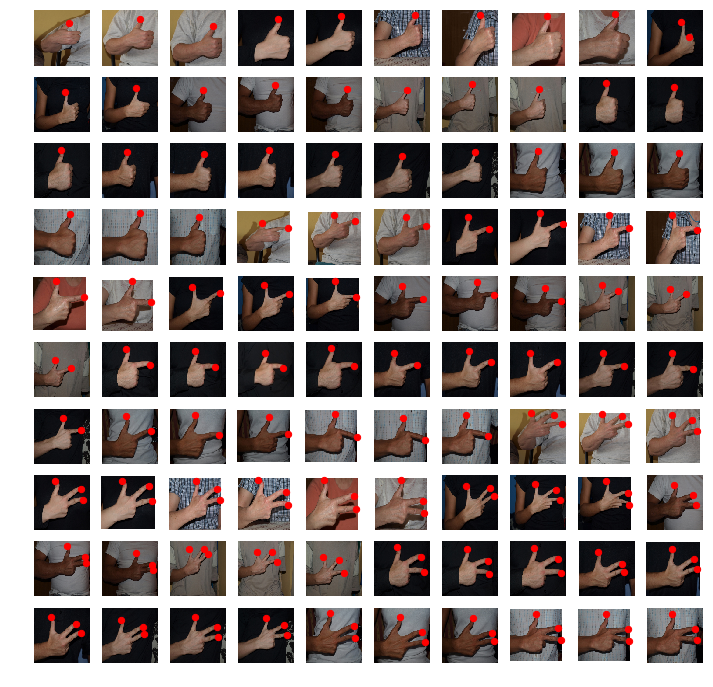

In [6]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))

for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(10,10,i+1)
    plt.imshow(x[i])
    plt.scatter(*y_finger_tips[i], c='r', s=40)
    plt.axis('off')

plt.show()

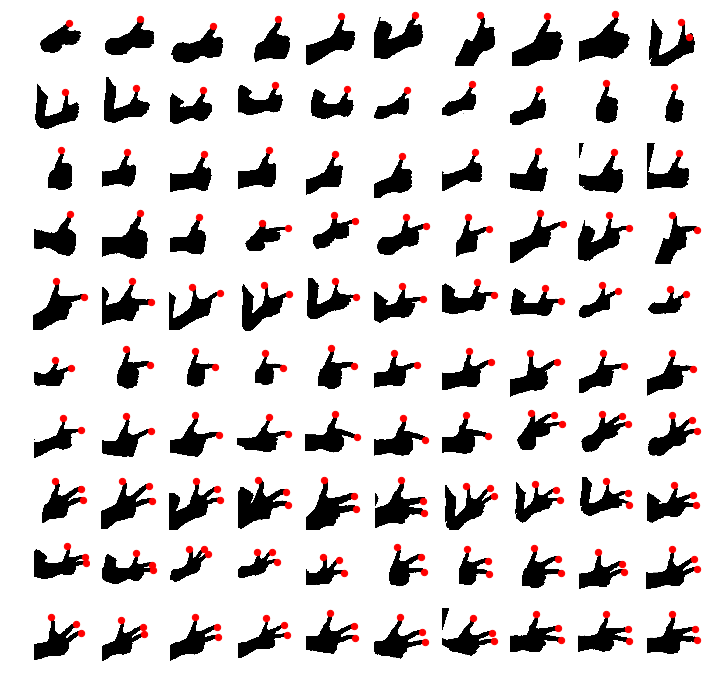

In [7]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))

for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(10,10,i+1)
    plt.imshow(y_skin_mask[i])
    plt.scatter(*y_finger_tips[i], c='r', s=40)
    plt.axis('off')

plt.show()

In [8]:
# This is perfect Dai. Augmentation might be tricky, especially with translation, because I have 
# to transform the points along with it. Should I do it now or later?

# First i will try to overfit lol.

In [9]:
print("Real image input size:", x.shape)

x = x.transpose(0, 3, 1, 2)

print("Real transposed image input size:", x.shape)

Real image input size: (899, 128, 128, 3)
Real transposed image input size: (899, 3, 128, 128)


In [10]:
# What is my input?
# What is my architecture?
import torch
import torch.functional as F
from torch.autograd import Variable
import torch.nn as nn

In [31]:
class DummyNet(nn.Module):
    def __init__(self, input_shape):
        
        super(DummyNet, self).__init__()
        
        channel, width, height = input_shape
        
        self.conv1 = nn.Conv2d(in_channels = channel, out_channels = 8, kernel_size = 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reduce by 2

        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.2)

        output_size = 16 * width / 2 * height / 2
        self.fc1 = nn.Linear(in_features = output_size, out_features = output_size)
        self.fc2 = nn.Linear(in_features = output_size, out_features = output_size)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x has shape: [N, C, W, H]
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.dropout1(x)
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))

        # Output shape is: [N, C, W, H]
        
        
        return x

In [13]:
# DO NOT feed every image at once, feed batch_size please
batch_size = 5

In [14]:
x_torch = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=False)

In [15]:
x_batch = x_torch[:batch_size]
print(x_batch.size())

torch.Size([5, 3, 128, 128])


In [35]:
net = DummyNet(x_batch.size()[1:]) # Don't count batch_size



TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (float, float), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mfloat[0m, [31;1mfloat[0m)
 * (torch.FloatTensor viewed_tensor)
 * (torch.Size size)
 * (torch.FloatStorage data)
 * (Sequence data)


In [16]:
channel, width, height = x_batch.size()[1:]

print(channel, width, height)

3 128 128


In [17]:
print(int(16 * width / 2 * height / 2))

65536


In [18]:
channel, width, height = x_batch.size()[1:]

conv1 = nn.Conv2d(in_channels = channel, out_channels = 8, kernel_size = 3, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reduce by 2

conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1)
dropout1 = nn.Dropout2d(p=0.2)

output_size = int(16 * width / 2 * height / 2)
fc1 = nn.Linear(in_features = output_size, out_features = 128)
fc2 = nn.Linear(in_features = 128, out_features = 128)

relu = nn.ReLU()
sigmoid = nn.Sigmoid()

In [ ]:
# How does the neural network output bounding boxes???

In [ ]:

# http://sun.aei.polsl.pl/~mkawulok/gestures/

# I'll start SUPER simple -> Dumb Conv, just do it.

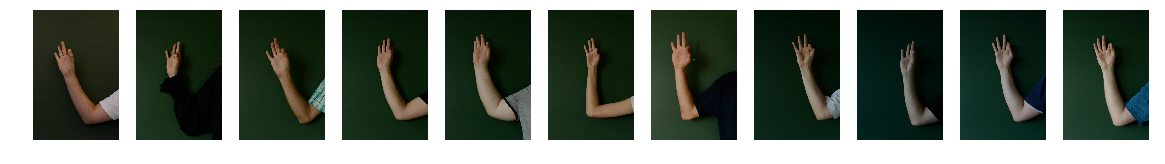

In [9]:
from skimage import io

files_6 = glob.glob('../data/original_images/9_*')

gs1 = gridspec.GridSpec(1, 11)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(20,20))

for i in range(11):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(1,11,i+1)
    
    image = io.imread(files_6[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()

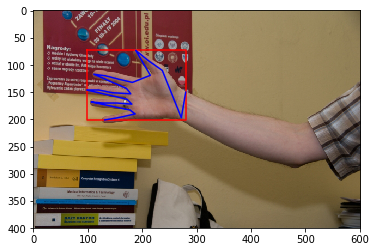

In [25]:
img_name = '5_A_hgr2A2_id03_1'

feature_points_file = etree.parse('../test_data/feature_points/' + img_name + '.xml')
root = feature_points_file.getroot()

xs, ys = [], []

for child in root:
    for element in child:
        xs.append(int(element.attrib.get('x')))
        ys.append(int(element.attrib.get('y')))
        
image = io.imread('../test_data/original_images/' + img_name + '.jpg')

plt.imshow(image)
plt.plot([min(xs), max(xs), max(xs), min(xs), min(xs)], 
         [min(ys), min(ys), max(ys), max(ys), min(ys)],
         "r-")
plt.plot(xs, ys, 'b-')

plt.show()

In [27]:
from scipy.misc import imread

ppm_file = '../test_data/Marcel-Train/A/A-train0001.ppm'
img = imread(ppm_file)


In [28]:
print(img.shape)

(76, 66, 3)
